# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Preparations" data-toc-modified-id="Preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparations</a></div><div class="lev2 toc-item"><a href="#Covariates" data-toc-modified-id="Covariates-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Covariates</a></div><div class="lev1 toc-item"><a href="#Optimization" data-toc-modified-id="Optimization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimization</a></div><div class="lev1 toc-item"><a href="#2-GP-posterior-with-SchDistr-covariate-treated-separately" data-toc-modified-id="2-GP-posterior-with-SchDistr-covariate-treated-separately-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2 GP posterior with <code>SchDistr</code> covariate treated separately</a></div><div class="lev1 toc-item"><a href="#Plugging-in-$\beta$-posterior-mean" data-toc-modified-id="Plugging-in-$\beta$-posterior-mean-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plugging in <span class="MathJax_Preview" style="color: inherit;"><span class="MJXp-math" id="MJXp-Span-20"><span class="MJXp-mi MJXp-italic" id="MJXp-Span-21">β</span></span></span><span class="MathJax MathJax_Processing" id="MathJax-Element-6-Frame" tabindex="0"></span><script type="math/tex" id="MathJax-Element-6">\beta</script> posterior mean</a></div><div class="lev1 toc-item"><a href="#Pull-in-more-data" data-toc-modified-id="Pull-in-more-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Pull in more data</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \newcommand{\gp}{\mathcal{GP}}
$$

In `Tucson_analysis_3`, I excluded `SchDistr` from the covariates. Here, I redo the analysis with it included to see if it makes a difference. I conclude that it hardly makes a difference.

Next, I just plug-in the posterior mean of the coefficients $\hat\beta$. Conditional on $\hat\beta$, the $\gp$'s are independent again, and things are simpler. Again, the results are largely unchanged from the full $\gp$ including the linear regression.

# Preparations

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end

In [3]:
recent = Tucson_sales[:,:SaleDate].>=201500
recent_in_believable = Tucson_sales[believable,:SaleDate].>201500
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
recent_Y_dict=Dict{String, Vector{Float64}}()
recent_X_dict=Dict{String, Array{Float64,2}}()
schdistrs = unique(Tucson_sales[:,:SchDistr])
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end
sum(recent & believable)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::DataFrames.DataFrame) at ./deprecated.jl:771
 in ctranspose(::DataFrames.DataFrame) at ./operators.jl:310
 in macro expansion; at ./In[3]:10 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:170
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:143
 in (::IJulia.##25#31)() at ./task.jl:360
while loading In[3], in expression starting on line 8


5349

In [4]:
recent_GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        println("no data for ", name)
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_GP_dict[name] = fit
end
schdistrs_have = collect(keys(recent_GP_dict))
recent_multiGP = GaussianProcesses.GP[recent_GP_dict[name] for name in schdistrs_have]
;

no data for Tanque Verde Unified District


In [5]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);

In [6]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP,1}

In [7]:
nobsv_ = sum([gp.nobsv for gp in recent_multiGP])
for_mm = copy(Tucson_sales[believable & recent,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
istart = 1
for name in schdistrs_have
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
;

## Covariates

This is the thing that changes: I'm now including `SchDistr` in the covariates. That way the linear regression can adjust the mean of the different school districts.

In [8]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE + SchDistr, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [9]:
size(D_)

(5349,30)

In [10]:
βkern_ = GaussianProcesses.LinIso(log(1.0))
type MultiGPCovars{MT<:GaussianProcesses.Mean, KT1<:GaussianProcesses.Kernel, KT2<:GaussianProcesses.Kernel}
    D::Array{Float64,2}
    y::Vector{Float64}
    mgp::MultiGP
    p::Int
    dim::Int
    nobsv::Int
    logNoise::Float64
    m::MT
    k::KT1
    βkern::KT2
    # Auxiliary data
    cK::PDMats.PDMat        # (k + obsNoise)
    alpha::Vector{Float64}  # (k + obsNoise)⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood
    function MultiGPCovars(D::Array{Float64,2}, 
        y::Vector{Float64},
        mgp::MultiGP, 
        p::Int,
        dim::Int,
        nobsv::Int,
        logNoise::Float64,
        m::MT,
        k::KT1,
        βkern::KT2
        )
        mgpcv = new(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
        update_mll!(mgpcv)
        return mgpcv
    end
end
function MultiGPCovars{KT2<:GaussianProcesses.Kernel}(D::Array{Float64,2}, mgp::MultiGP, βkern::KT2)
    nobsv = sum([gp.nobsv for gp in mgp])
    size(D,1) == nobsv || throw(ArgumentError("incompatible dimensions of covariates matrix and gaussian processes"))
    first_gp = mgp[1]
    dim = first_gp.dim
    logNoise = first_gp.logNoise
    k = first_gp.k
    m = first_gp.m
    # harmonize parameters
    for gp in mgp
        gp.k = k
        gp.m = m
        gp.logNoise = logNoise
    end
    p = size(D,2)
    y = vcat([gp.y for gp in mgp]...)
    mgpcv = MultiGPCovars{typeof(m),typeof(k),KT2}(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
    return mgpcv
end

MultiGPCovars{MT<:GaussianProcesses.Mean,KT1<:GaussianProcesses.Kernel,KT2<:GaussianProcesses.Kernel}

In [11]:
function propagate_params!(mgpcv::MultiGPCovars)
    for gp in mgpcv.mgp
        # harmonize parameters
        gp.k = mgpcv.k
        gp.m = mgpcv.m
        gp.logNoise = mgpcv.logNoise
    end
end

function update_mll!(mgpcv::MultiGPCovars, cK::Matrix{Float64})
    propagate_params!(mgpcv)
    cov!(cK, mgpcv.βkern, mgpcv.D')
#     ell = exp(mgpcv.βkern.ll)
#     Base.LinAlg.BLAS.gemm!('N', 'T', 1/ell^2, mgpcv.D, mgpcv.D, 0.0, cK)
#     Base.LinAlg.copytri!(cK, 'U')
    m = Array(Float64, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        m[istart+1:istart+gp.nobsv] = mean(mgpcv.m,gp.X)
        addcov!(view(cK, istart+1:istart+gp.nobsv, istart+1:istart+gp.nobsv), mgpcv.k, gp.X, gp.data)
        istart += gp.nobsv
    end
    for i in 1:mgpcv.nobsv
        cK[i,i] += max(exp(2*mgpcv.logNoise),1e-8)
    end
    mgpcv.cK = PDMats.PDMat(cK)
    mgpcv.alpha = mgpcv.cK \ (mgpcv.y .- m)
    mgpcv.mLL = -dot((mgpcv.y-m),mgpcv.alpha)/2.0 - logdet(mgpcv.cK)/2.0 - mgpcv.nobsv*log(2π)/2.0
end

function update_mll!(mgpcv::MultiGPCovars)
    cK_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv)
    update_mll!(mgpcv, cK_buffer)
end
function update_mll_and_dmll!(mgpcv::MultiGPCovars,
    cK::Matrix{Float64},
    Kgrad::Array{Float64,2}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!(mgpcv, cK)
    n_mean_params = GaussianProcesses.num_params(mgpcv.m)
    n_kern_params = GaussianProcesses.num_params(mgpcv.k)
    n_beta_params = GaussianProcesses.num_params(mgpcv.βkern)
    dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = mgpcv.logNoise
    α = mgpcv.alpha
    ααinvcKI = α*α' - mgpcv.cK \ eye(mgpcv.nobsv)
    i=1
    if noise
        dmLL[i] = exp(2*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = vcat([GaussianProcesses.grad_stack(gp.m, gp.X) for gp in mgpcv.mgp]...)
        for j in 1:n_mean_params
            dmLL[i] = dot(Mgrads[:,j],α)
            i+=1
        end
    end
    if kern
        Kgrad[:,:] = 0.0
        for j in i:i+n_kern_params-1
            dmLL[j] = 0.0
        end
        for iparam in 1:n_kern_params
            istart=0
            for gp in mgpcv.mgp
                Kview = view(Kgrad, istart+1:istart+gp.nobsv, istart+1:istart+gp.nobsv)
                ααview = view(ααinvcKI, istart+1:istart+gp.nobsv, istart+1:istart+gp.nobsv)
                grad_slice!(Kview, mgpcv.k, gp.X, gp.data, iparam)
                Kview[:,:] .*= ααview
                dmLL[i] += sum(Kview)/2
                istart += gp.nobsv
            end
            i+=1
        end
    end
    if beta
        for iparam in 1:num_params(mgpcv.βkern)
            grad_slice!(Kgrad, mgpcv.βkern, mgpcv.D', KernelData(mgpcv.βkern,mgpcv.D'), iparam)
            dmLL[i] = dot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
    mgpcv.dmLL = dmLL
end
function get_params(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, mgpcv.logNoise); end
    if mean;  append!(params, GaussianProcesses.get_params(mgpcv.m)); end
    if kern; append!(params,  GaussianProcesses.get_params(mgpcv.k)); end
    if beta; append!(params,  GaussianProcesses.get_params(mgpcv.βkern)); end
    return params
end
function set_params!(mgpcv::MultiGPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        mgpcv.logNoise = hyp[i]
        i+=1
    end
    if mean
        GaussianProcesses.set_params!(mgpcv.m, hyp[i:i+GaussianProcesses.num_params(mgpcv.m)-1])
        i+=GaussianProcesses.num_params(mgpcv.m)
    end
    if kern
        GaussianProcesses.set_params!(mgpcv.k, hyp[i:i+GaussianProcesses.num_params(mgpcv.k)-1])
        i+=GaussianProcesses.num_params(mgpcv.k)
    end
    if beta
        GaussianProcesses.set_params!(mgpcv.βkern, hyp[i:i+GaussianProcesses.num_params(mgpcv.βkern)-1])
        i+=GaussianProcesses.num_params(mgpcv.βkern)
    end
    propagate_params!(mgpcv)
end
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gp::GP`: Predefined Gaussian process type
* `noise::Bool`: Noise hyperparameters should be optmized
* `mean::Bool`: Mean function hyperparameters should be optmized
* `kern::Bool`: Kernel function hyperparameters should be optmized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function GaussianProcesses.optimize!(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    cK_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv)
    Kgrad_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!(mgpcv, cK_buffer)
            return -mgpcv.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(mgpcv, cK_buffer, Kgrad_buffer; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -mgpcv.dmLL
            return -mgpcv.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(mgpcv;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    return results
end
mgpcv=MultiGPCovars(D_, recent_multiGP::MultiGP, βkern_);

# Optimization

In [12]:
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        mean=true,
        iterations=10,
        x_tol=1e-3,
        f_tol=1e-3,
    )

Base.LinAlg.PosDefException(2810)
New linesearch
bracketing: ia = 1, ib = 2, c = 0.0020000000000000005, phic = 29976.202401899714, dphic = 1.8680497103696812e7
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.0020000000000000005, phi(a) = -1004.7569486408483, phi(b) = 29976.202401899714
secant2: a = 0.0, b = 0.0020000000000000005, c = 0.0008146698901571953
update: ia = 1, a = 0.0, ib = 2, b = 0.0020000000000000005, c = 0.0008146698901571953, phic = 7985.411922077747, dphic = 1.7942812342501327e7
secant2: iA = 1, iB = 3, ic = 3
secant2 output: a = 0.0, b = 0.0008146698901571953
Linesearch: secant succeeded
linesearch: ia = 1, ib = 3, a = 0.0, b = 0.0008146698901571953, phi(a) = -1004.7569486408483, phi(b) = 7985.411922077747
secant2: a = 0.0, b = 0.0008146698901571953, c = 0.0003397961332304011
update: ia = 1, a = 0.0, ib = 3, b = 0.0008146698901571953, c = 0.0003397961332304011, phic = 387.58178583892186, dphic = 1.2635139533078505e7
secant2: iA = 1, iB = 4, ic = 4
secant2 output: a = 0.0, b

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-2.3025850929940455,11.766598687771586, ...]
 * Minimizer: [-1.8661962823351208,11.766949193879018, ...]
 * Minimum: -1.597914e+03
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 1.0e-03: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 27
 * Gradient Calls: 18

In [13]:
opt_output

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-2.3025850929940455,11.766598687771586, ...]
 * Minimizer: [-1.8661962823351208,11.766949193879018, ...]
 * Minimum: -1.597914e+03
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 1.0e-03: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 27
 * Gradient Calls: 18

In [14]:
k=mgpcv.k
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(k.σ2))
@printf("σ_β: %.4f\n", 1/√mgpcv.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(k.ℓ2))

σ_y: 0.1547
σ_f: 0.1830
σ_β: 0.8767
ℓ: 1748.5162


In [15]:
print(opt_output.minimum)

[-1.8662,11.7669,7.46652,-1.69822,0.131562]

# 2 GP posterior with `SchDistr` covariate treated separately

In [16]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"

"Tucson Unified District"

In [17]:
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
size(X◫)

(2,100)

In [18]:
n◫ = size(X◫, 2)
cK_A = cov(mgpcv.k, X◫, recent_X_dict[distrA]') .+ 1/mgpcv.βkern.ℓ2
cK_B = cov(mgpcv.k, X◫, recent_X_dict[distrB]') .+ 1/mgpcv.βkern.ℓ2
;

In [19]:
A_indices = find(for_mm[:SchDistr] .== distrA)
B_indices = find(for_mm[:SchDistr] .== distrB)
AB_indices = vcat(A_indices, B_indices)
cK_AB = zeros(Float64, 2n◫, mgpcv.nobsv)
cK_AB[1:n◫,A_indices] = cK_A
cK_AB[n◫+1:2n◫,B_indices] = cK_B
;

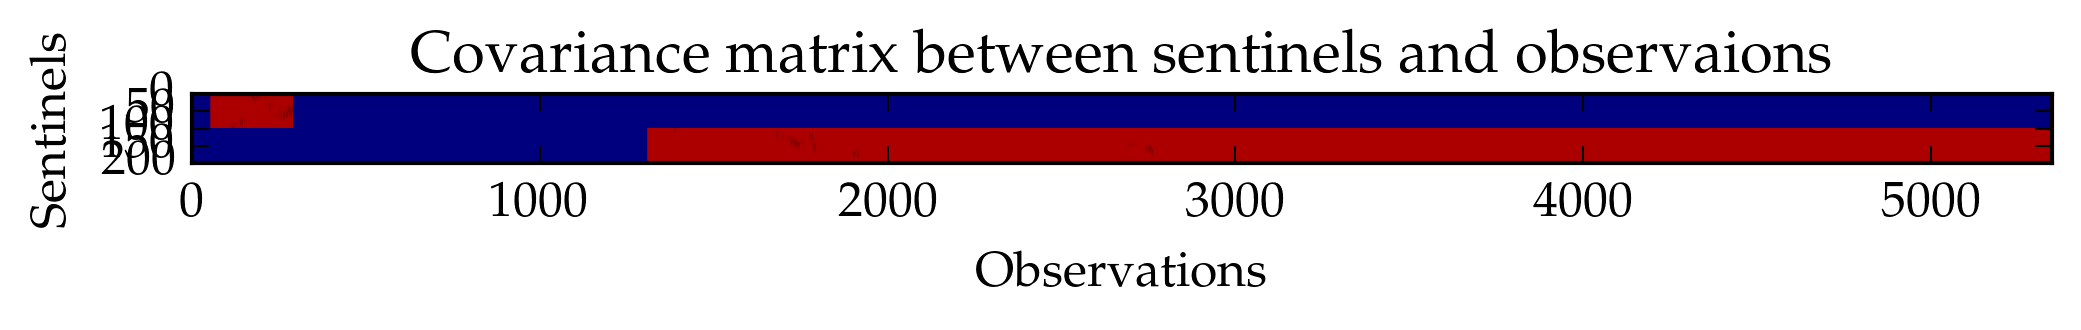

In [20]:
plt.imshow(cK_AB)
plt.title("Covariance matrix between sentinels and observaions")
plt.xlabel("Observations")
plt.ylabel("Sentinels")
;

In [21]:
mu = [mean(mgpcv.m,X◫); mean(mgpcv.m,X◫)] + cK_AB*mgpcv.alpha;
Sigma_prior = cat([1,2], cov(mgpcv.k, X◫).+ 1/mgpcv.βkern.ℓ2, cov(mgpcv.k, X◫).+ 1/mgpcv.βkern.ℓ2)
# Sigma_raw = Sigma_prior - Lck'Lck
Sigma_raw = Sigma_prior - PDMats.Xt_invA_X(mgpcv.cK, cK_AB');
μposterior = mu[1:n◫].-mu[n◫+1:2n◫]
Σposterior=Sigma_raw[1:n◫,1:n◫]+Sigma_raw[n◫+1:2n◫,n◫+1:2n◫]-Sigma_raw[1:n◫,n◫+1:2n◫]-Sigma_raw[n◫+1:2n◫,1:n◫]
;

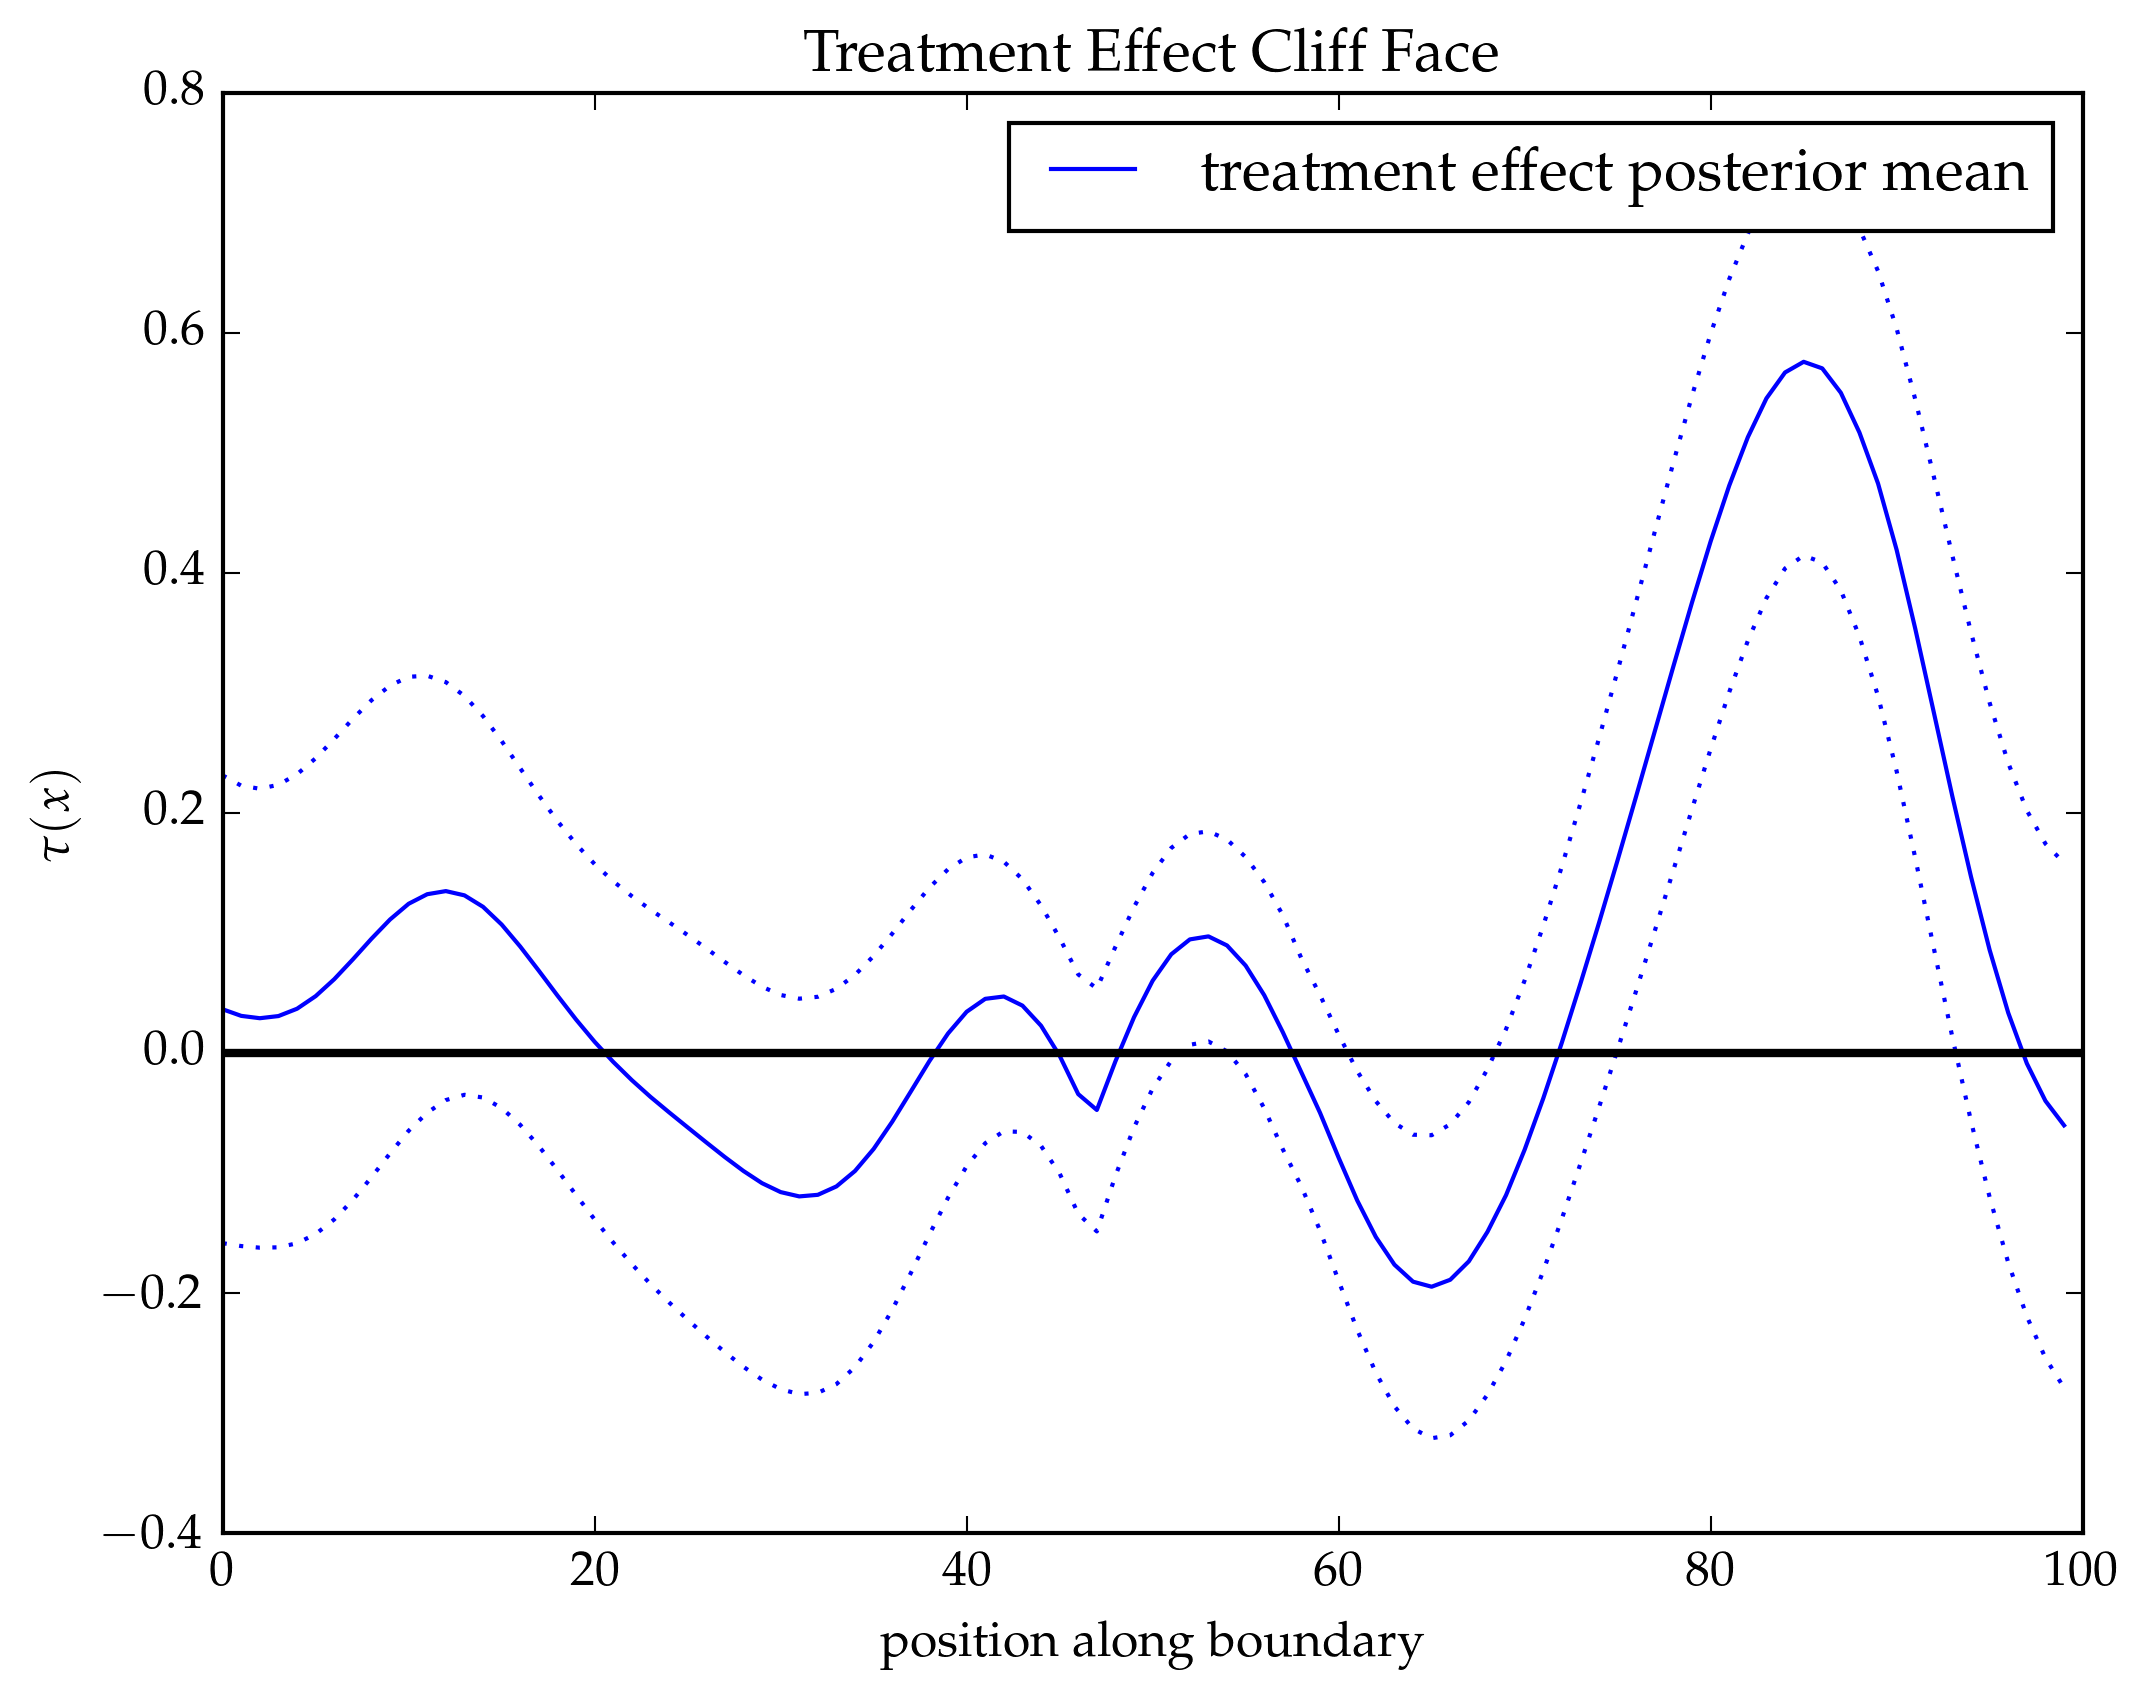

In [22]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

This has made almost no difference to the end result.

# Plugging in $\beta$ posterior mean

It might be that fitting the $\beta$ linear regression parameters as part of the $\gp$ is somehow affecting the results. We believe that we have enough data that the regression parameters should be known fairly precisely, so we wouldn't think this would made a difference, but there's also always a (large) chance that there's a bug in my code. So, to make sure we know what's going on, we'll first find the posterior mean of the regression parameters, but this time *without* treating the data as iid. Instead we'll incorporate the spatial structure in the covariance matrix used to fit the parameters. The estimates are given by:

$$\hat{\beta} = \del{D^\intercal \Sigma_{Y\mid\beta}^{-1}D + \Sigma_\beta^{-1}}^{-1} D^\intercal\Sigma_{Y\mid\beta}^{-1} Y$$

where $D$ is the model matrix, $\Sigma_{Y\mid\beta}$ is the covariance of $Y$ for a fixed $\beta$ and $\Sigma_\beta$ is the prior variance on $\beta$.

In [23]:
function get_ΣYβ!(mgpcv::MultiGPCovars)
    Σ = zeros(Float64, mgpcv.nobsv, mgpcv.nobsv)
    propagate_params!(mgpcv)
    istart=0
    for gp in mgpcv.mgp
        addcov!(view(Σ,istart+1:istart+gp.nobsv,istart+1:istart+gp.nobsv), mgpcv.k, gp.X, gp.data)
#         R = distance(mgpcv.k, gp.X, gp.data)
#         for j in 1:gp.nobsv
#             for i in 1:gp.nobsv
#                 @inbounds Σ[istart+i,istart+j] = cov(mgpcv.k, R[i,j])
#             end
#         end
        istart += gp.nobsv
    end
    for i in 1:mgpcv.nobsv
        Σ[i,i] += max(exp(2*mgpcv.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end

get_ΣYβ! (generic function with 1 method)

In [24]:
ΣY_β = get_ΣYβ!(mgpcv);

In [25]:
tmp = PDMats.Xt_invA_X(ΣY_β, D_)
for i in 1:p
    tmp[i,i] += mgpcv.βkern.ℓ2
end
m = Array(Float64, mgpcv.nobsv)
istart=0
for gp in mgpcv.mgp
    m[istart+1:istart+gp.nobsv] = mean(mgpcv.m,gp.X)
    istart += gp.nobsv
end
βhat = (tmp \ D_') * (ΣY_β \ (mgpcv.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

Dict{String,Float64} with 30 entries:
  "ROOF: Built Up" => -0.0107621
  "CLASS: R-4" => 0.249832
  "ROOF: Metal" => 0.110838
  "CLASS: R-2" => -0.150576
  "CLASS: R-1" => -0.455549
  "ROOF: Other" => -0.0129412
  "ROOF: Tile" => -0.0113554
  "ROOF: Wood" => -0.0473607
  "SchDistr: Vail Unified District" => 0.0629957
  "QUALITY: Good" => 0.0432198
  "ROOF: Prepared Roll" => -0.0132828
  "SchDistr: Tucson Unified District" => 0.0786033
  "GARAGE: Garage" => 0.0592563
  "QUALITY: Excellent" => 0.21262
  "ROOF: Asphalt" => -0.0229131
  "GARAGE: None" => -0.039294
  "STORIES" => -0.0935618
  "GARAGE: Carport" => -0.0124403
  "QUALITY: Minimum" => -0.161376
  "(Intercept)" => 0.0649819
  "CLASS: R-5" => 0.371386
  "CLASS: R-3" => 0.0498892
  "SchDistr: Amphitheater Unified District" => 0.10598
  "ROOF: Slate" => 0.0768841
  "SQFT" => 0.198684
  "QUALITY: Fair" => -0.0294827
  "ROOF: Asbestos" => -0.00412436
  "GARAGE: Garage & Carport (both)" => 0.0574599
  "SchDistr: Flowing Wells Unified 

In [26]:
for (key, val) in recent_Y_dict
    @printf("%20s: %8.4f\n", key, mean(val))
end

Flowing Wells Unified District:  11.7666
Tanque Verde Unified District:      NaN
Amphitheater Unified District:  11.9020
Sunnyside Unified District:  11.6245
Vail Unified District:  12.1934
Tucson Unified District:  11.9709


In [27]:
βhat_noschdistr = copy(βhat)
βhat_noschdistr[[contains(x,"SchDistr: ") for x in coefnames(mf)]] = 0.0
resid = mgpcv.y - D_*βhat_noschdistr

resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs_have
    resid_dict[name] = resid[for_mm[:SchDistr].==name]
end

Once we have the residuals, we go back to treating to fitting separate GPs for each region, so we don't have to use the machinery that we built to handle covariates inside the GP. This is a nice way to check that our results aren't due to a bug in my code.

In [28]:
resid_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = recent_X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, mgpcv.m, mgpcv.k, mgpcv.logNoise)
    resid_GP_dict[name] = fit
end

In [29]:
resid_pred_A = GaussianProcesses.predict(resid_GP_dict[distrA], X◫; full_cov=true)
resid_pred_B = GaussianProcesses.predict(resid_GP_dict[distrB], X◫; full_cov=true)
;

In [30]:
resid_μposterior = resid_pred_A[1].-resid_pred_B[1]
resid_Σposterior = resid_pred_A[2]+resid_pred_B[2]
;

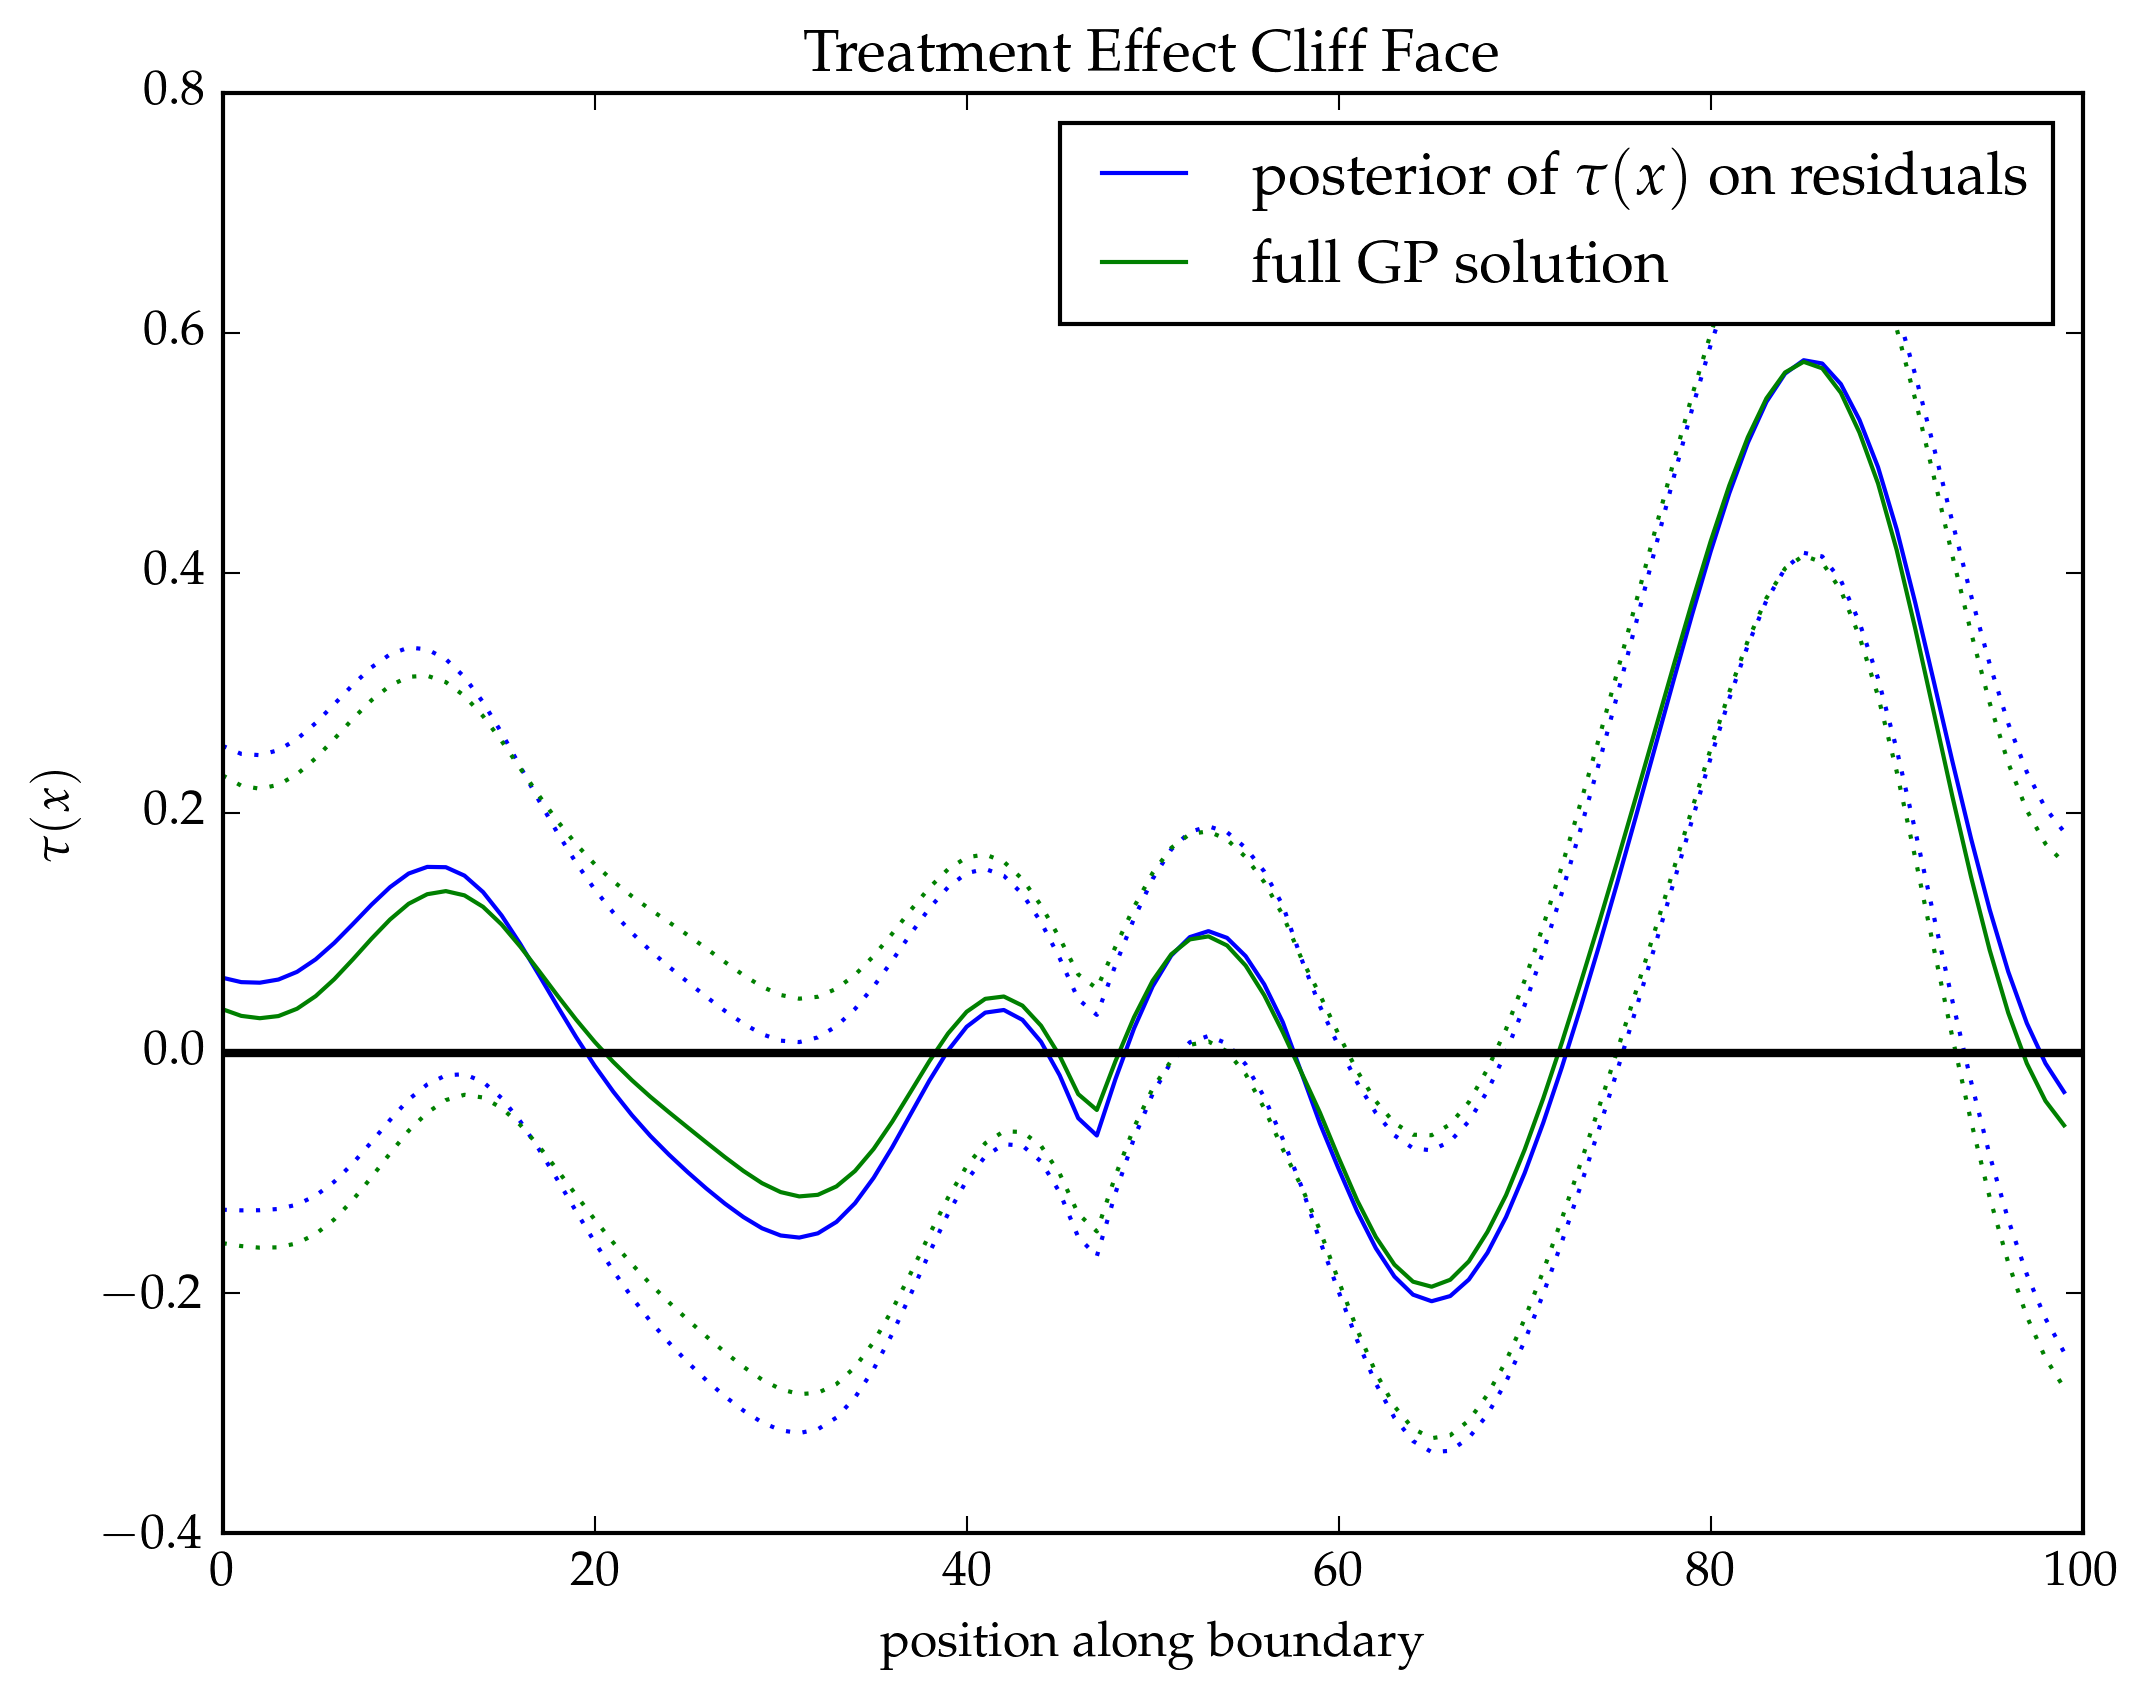

In [31]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(μposterior, color="green", label="full GP solution")
plt.plot(μposterior.+√diag(Σposterior), color="green", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="green", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

# Pull in more data

In [ ]:
X

In [32]:
# all_GP_dict=Dict{String, GP}()
# _m = mgpcv.m
# _kern = mgpcv.k
# _logNoise = mgpcv.logNoise
# for name in schdistrs
#     X = X_dict[name]
#     Y = Y_dict[name]
#     if length(Y)==0
#         println("no data for ", name)
#         continue
#     end
#     fit = GP(X', Y, _m, _kern, _logNoise)
#     all_GP_dict[name] = fit
# end
# all_schdistrs_have = collect(keys(recent_GP_dict))

5-element Array{String,1}:
 "Flowing Wells Unified District"
 "Amphitheater Unified District" 
 "Sunnyside Unified District"    
 "Vail Unified District"         
 "Tucson Unified District"       

In [33]:
# all_multiGP = GaussianProcesses.GP[all_GP_dict[name] for name in all_schdistrs_have]
# ;

In [34]:
# for_mm_all = copy(Tucson_sales[believable,:])
# for_mm_all[:SQFT] =  for_mm_all[:SQFT] .- mean(for_mm_all[:SQFT])
# for_mm_all[:SQFT] = for_mm_all[:SQFT] ./ std(for_mm_all[:SQFT])
# for_mm_all[:ROOMS] = for_mm_all[:ROOMS] .- mean(for_mm_all[:ROOMS])
# for_mm_all[:ROOMS] = for_mm_all[:ROOMS] ./ std(for_mm_all[:ROOMS])
# for_mm_all[:STORIES] = for_mm_all[:STORIES] .- mean(for_mm_all[:STORIES])
# for_mm_all[:STORIES] = for_mm_all[:STORIES] ./ std(for_mm_all[:STORIES])
# reordering = collect(1:sum(gp.nobsv for gp in all_multiGP))
# istart = 1
# for name in all_schdistrs_have
#     indices = find(for_mm_all[:SchDistr] .== name)
#     nobsv_schdistr = length(indices)
#     iend = istart+nobsv_schdistr-1
#     reordering[istart:iend,:] = indices
#     istart = iend+1
# end
# for_mm_all = for_mm_all[reordering,:]
# ;

In [35]:
mf_all=DataFrames.ModelFrame(logSalePrice ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE + SchDistr, 
    for_mm_all, 
    contrasts=contrasts_dict)
mm_all=ModelMatrix(mf_all)
D_all=mm_all.m;

In [39]:
mgpcv_all=MultiGPCovars(D_all, all_multiGP::MultiGP, mgpcv.βkern);

In [40]:
ΣY_β_all = get_ΣYβ!(mgpcv_all);

In [42]:
tmp = PDMats.Xt_invA_X(ΣY_β_all, D_all)
for i in 1:p
    tmp[i,i] += mgpcv_all.βkern.ℓ2
end
m = Array(Float64, mgpcv_all.nobsv)
istart=0
for gp in mgpcv_all.mgp
    m[istart+1:istart+gp.nobsv] = mean(mgpcv_all.m,gp.X)
    istart += gp.nobsv
end
βhat_all = (tmp \ D_all') * (ΣY_β_all \ (mgpcv_all.y.-m))
βhat_dict_all=Dict(zip(coefnames(mf_all), βhat_all))

Dict{String,Float64} with 31 entries:
  "ROOF: Built Up" => -0.0214866
  "CLASS: R-4" => 0.351965
  "ROOF: Metal" => 0.120571
  "CLASS: R-6" => -0.702584
  "CLASS: R-2" => -0.0652347
  "CLASS: R-1" => -0.25418
  "ROOF: Other" => -0.00540256
  "ROOF: Tile" => -0.0156204
  "ROOF: Wood" => -0.0404593
  "SchDistr: Vail Unified District" => 0.117966
  "QUALITY: Good" => -0.0100036
  "ROOF: Prepared Roll" => -0.0091547
  "SchDistr: Tucson Unified District" => 0.0955914
  "GARAGE: Garage" => 0.020951
  "QUALITY: Excellent" => 0.142049
  "ROOF: Asphalt" => -0.0223227
  "GARAGE: None" => -0.0715118
  "STORIES" => -0.0960439
  "GARAGE: Carport" => -0.0479487
  "QUALITY: Minimum" => -0.136178
  "(Intercept)" => -0.0833216
  "CLASS: R-5" => 0.411689
  "CLASS: R-3" => 0.175024
  "SchDistr: Amphitheater Unified District" => 0.0868695
  "ROOF: Slate" => -0.067442
  "SQFT" => 0.197347
  "QUALITY: Fair" => -0.0791887
  "ROOF: Asbestos" => -0.0220041
  "GARAGE: Garage & Carport (both)" => 0.0151879
  "S